#### License

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY  - Creative Commons Attribution 4.0 International License</a>.

#### Preliminaries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, FloatSlider
from IPython.display import display
import colour as cs
import matplotlib.colors as clr

In [2]:
from matplotlib import rc
font = {'size'   : 15}
rc('font', **font)

#### Load data for seismic subplot

This is one crossline from the [Penobscot 3D](https://terranubis.com/datainfo/Penobscot) ([CC BY-SA license](https://creativecommons.org/licenses/by-sa/3.0/)).

In [3]:
data_folder = "./data"
traces = np.loadtxt(os.path.join(data_folder,'PenobXL_1155.txt'))

In [4]:
traces = np.fliplr(np.transpose(traces)) # rearrange traces for plotting
m=np.amin(traces)
M=np.amax(traces)

#### Helper functions

In [5]:
def sigmoid(w):
    """ 
    Makes a sigmoid curve; the center of the curve is fixed at 5.  
    
    Parameter:
        w (int): the sigmoid width   
        
    Returns:
        sgm (array): the 1D sigmoid curve
    """
    x = np.linspace(0,10,256) # range = 0-10
    sgm = 1/(1+np.exp(-(x-5)/(w+0.001)))     # sigmoid curve (+0.001 to avoid dividing by w=0)
    sgm = (sgm-min(sgm))/(max(sgm)-min(sgm)) # normalize so y is in range 0-1
    return sgm                               # this is used as Lightnes in the rgb_sigmoid function


def rgb_sigmoid(sgm):
    """ 
    Makes an RGB array of size 256x3, which can then be plotted as rectuangular colorbar image.
    
    Parameters:
        sgm (array): sigmoid 1D curve. Can be output of sigmoid function   
    
    Returns:
        rgb_sigmoid (array): the 256x3 RGB array
    """
    h = np.zeros(256)
    s = np.zeros(256)
    hsl_sigm = np.array(list(zip(h, s, sgm))) # Hue-Saturation-Lightness sigmoid array
    # next block to convert sigmoid array from HLS to RGB 
    rgb_sigm = []
    for hls_val in hsl_sigm:
        h,s,l = hls_val
        temp = cs.HSL_to_RGB([h,s,l])
        rgb_sigm.append(temp)
    rgb_sigm= np.array(rgb_sigm)
    rgb_sigmoid = np.array(list(zip(rgb_sigm[:,0], rgb_sigm[:,1], rgb_sigm[:,2]))) 
    return rgb_sigmoid


def rgb_cmap(rgb_sigmoid):
    """ 
    Makes a Matplotlib LinearSegmentedColormap RGB sigmoid grayscale
    
    Parameters:
        rgb_sigmoid (array): sigmoid RGB array. Can be output of rgb_sigmoid function   
    
    Returns:
        my_sigmoid_cmap: LinearSegmentedColormap
    """
    r3=r2=rgb_sigmoid[:,0] # value of red at sample n
    r1=np.linspace(0,1,len(r2)) # position of sample n - ranges from 0 to 1
    g3=g2=rgb_sigmoid[:,1]
    g1=np.linspace(0,1,len(g2))
    b3=b2=rgb_sigmoid[:,2]
    b1=np.linspace(0,1,len(b2)) 
    r=zip(r1,r2,r3) # red list
    g=zip(g1,g2,g3) # green list
    b=zip(b1,b2,b3) # blue list
    rgb_=zip(r,g,b) # creating final list
    rgb=zip(*rgb_)  # transposing list
    k=['red', 'green', 'blue'] # keys
    sigmoid_gray=dict(zip(k,rgb)) # makes a dictionary for LinearSegmentedColormap
    my_sigmoid_cmap = clr.LinearSegmentedColormap('my_colormap',sigmoid_gray)
    return my_sigmoid_cmap

#### Interactive colormap

First define the function to do all the interactive plotting and also output array.

In [6]:
def sigmoid_demo(w):  
    """This makes an interactive figure where the parameter w - the width of the 
    sigmoid curve - is controlled by a slider. Stepping through values of w will show,
    in 4 different plots respectively, the changes in:
    - the shape of the sigmoid curve
    - the resulting colormap plotted as rectangular colorbar image
    - the colormap lightness contrast in the central portion of the colormap
    - the effect on a seismic vertical section"""
   
    # set up variables
    xspl = np.linspace(0,256,256)           # Sample number of colormap
    sn = sigmoid(w)                         # Lightness in the range 0-1
    snc = sn*100                            # Lightness in the range 0-100
    ctr = (snc[128] - snc[127])             # Lightness contrast value
    rgb_sigm = rgb_sigmoid(sn)              # RGB sigmoid array
    my_sigmoid_cmap = rgb_cmap(rgb_sigm)    # Linear Segmented (sigmoid) Colormap
   
    # set up figure
    fig = plt.figure(figsize=(20,18))
    
    #  sigmoid subplot
    ax1 = plt.subplot2grid((8,5), (0,0),colspan=2, rowspan = 1)
    plt.plot(xspl,snc,lw=2,color='black') # lightness in the range 0-100
    plt.xlim(xspl.min(), xspl.max())
    plt.ylim(0, 100)
    ax1.set_ylabel('Lightness', fontsize = '12')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_xlabel('Colormap sample number', fontsize = '12' )
    
    # colorbar subplot
    ax2 = plt.subplot2grid((8,5), (1,0),colspan=2, rowspan = 2)
    ax2.set_yticks([])
    plt.imshow([rgb_sigm], interpolation = 'none', cmap = 'gray', aspect = 70)
    ax2.set_xlabel('Colormap sample number', fontsize = '12' )
    ax2.tick_params(axis='both', which='major', labelsize=10)
        
    # textbox plots of contrast value in the center of the colormap
    ax3 = plt.subplot2grid((8,5), (4,0), colspan=1, rowspan = 1)
    ax3.set_axis_off()
    bbox_props = dict(boxstyle="square, pad=0.5", fc="white", ec="0.5")
    ax3.text(0.65, 2, 'Lightness contrast = {0:.2f}'.format(ctr), ha="center", 
                 va="center", size=18, bbox=bbox_props)
       
    # seismic subplot
    ax4 = plt.subplot2grid((8,5), (0,2),colspan = 3, rowspan = 5)
    plt.imshow(traces[:750,100:], vmin=m, vmax=M, cmap = my_sigmoid_cmap, aspect = 0.5)
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    plt.show()
    
    return rgb_sigm # this is used as output array

Second, call the function and display the interactive plots.

In [7]:
np.seterr(over='ignore')
rslt = interactive(sigmoid_demo, w=FloatSlider(min=-2.7, max=2.7, step=0.1, value = 1))

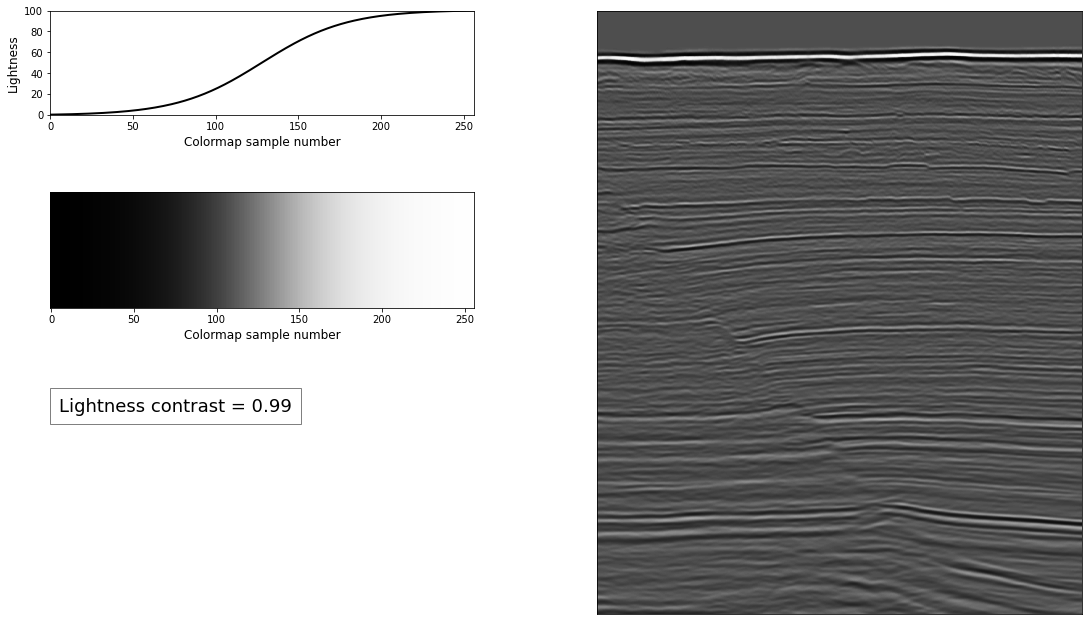

In [8]:
display(rslt)

#### Access the selected parameter and the resulting colormap array, and save the latter to a file

Using interactive instead of interact makes it possible to access the returned array in later cells, see:
https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#interactive

In [9]:
print('w =', rslt.children[0].value)

w = 1.0


In [10]:
#print(rslt.result[:5])

In [11]:
save_sigmoid_gray = np.round(rslt.result, decimals=4)

In [12]:
print(save_sigmoid_gray[:5])

[[ 0.      0.      0.    ]
 [ 0.0003  0.0003  0.0003]
 [ 0.0006  0.0006  0.0006]
 [ 0.0008  0.0008  0.0008]
 [ 0.0011  0.0011  0.0011]]


In [13]:
#np.savetxt('rgb_sigmoid_grays.txt',save_sigmoid_gray,delimiter=',', fmt='%1.4f')